# Predicting March Madness Wins

This notebook builds and evaluates a logistic regression model to predict which mens college basketball teams will win in a given March Madness bracket. In the companion notebook "Key_Factors_in_College_Basketball_Wins", I build and evaluates a random forest model to determine the characteristics that influence the win/loss %. Both notebooks rely on webscrapped data from https://www.sports-reference.com/cbb/.

**Importantly**, if utilizing this notebook to predict the March Madness winner before or after the 2025 season, there are necessary mannual mapping adjustments in Step 2 and 7. 

# 1: Setup Environment

## Import Libraries & Packages


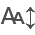

In [5]:
# pip install lxml
# pip install itables
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import time
from scipy.stats import uniform
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, KFold
import scipy.stats as ss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
import warnings
warnings.filterwarnings("ignore")

## Setup Global Variables

In [7]:
latest_season = int('2025')
SEED = 24
train_size = 0.75
CPUS = multiprocessing.cpu_count()

# 2: Setup Combined DataFrame

## Completed March Madness Brackets

### Webscraping

In [11]:
def parse_team_score(team_div):
    span = team_div.find("span")
    seed = int(span.text.strip()) if span and span.text.strip().isdigit() else None
    links = team_div.find_all("a")
    school = links[0].text.strip() if links else None
    points = int(links[-1].text.strip()) if links and links[-1].text.strip().isdigit() else None
    return seed, school, points


combined_brackets = pd.DataFrame()
for year in range(2005, 2025):
    print(f"Scraping {year}")
    url = f"https://www.sports-reference.com/cbb/postseason/men/{year}-ncaa.html"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 Chrome/114 Safari/537.36"}
    r = requests.get(url, headers=headers)
    soup = BeautifulSoup(r.content, "html.parser")
    brackets_container = soup.find("div", id="brackets")
    if not brackets_container:
        raise ValueError("Could not find brackets container")
    all_rows = []
    for region_div in brackets_container.find_all("div", recursive=False):
        region_id = region_div.get("id", "Unknown")
        region_name = region_id.capitalize() if region_id else "Unknown"
        bracket_div = region_div.find("div", id="bracket")
        if not bracket_div:
            continue
        rounds = bracket_div.find_all("div", class_="round")
        for round_num, round_div in enumerate(rounds, start=1):
            game_divs = [div for div in round_div.find_all("div", recursive=False) if div.find("div", class_="winner")]
            for game in game_divs:
                winner_div = game.find("div", class_="winner")
                loser_div = [d for d in game.find_all("div", recursive=False) if d != winner_div and d.name == "div"][0]
                w_seed, w_school, w_points = parse_team_score(winner_div)
                l_seed, l_school, l_points = parse_team_score(loser_div)
                all_rows.append({
                    "Region": region_name,
                    "Round": round_num,
                    "Seed": w_seed,
                    "School Name": w_school,
                    "Opponent": l_school,
                    "Points": w_points,
                    "Result": "W"
                })
                all_rows.append({
                    "Region": region_name,
                    "Round": round_num,
                    "Seed": l_seed,
                    "School Name": l_school,
                    "Opponent": w_school,
                    "Points": l_points,
                    "Result": "L"
                })
    df = pd.DataFrame(all_rows)
    df['Season'] = year
    combined_brackets = pd.concat([df,combined_brackets],ignore_index=True)  # Create a combined dataframe that includes each season and the corresponding data
combined_brackets

Scraping 2005
Scraping 2006
Scraping 2007
Scraping 2008
Scraping 2009
Scraping 2010
Scraping 2011
Scraping 2012
Scraping 2013
Scraping 2014
Scraping 2015
Scraping 2016
Scraping 2017
Scraping 2018
Scraping 2019
Scraping 2020
Scraping 2021
Scraping 2022
Scraping 2023
Scraping 2024


Region  Round  Seed       School Name          Opponent  Points  \
0         East    1.0   1.0             UConn           Stetson    91.0   
1         East    1.0  16.0           Stetson             UConn    52.0   
2         East    1.0   9.0      Northwestern  Florida Atlantic    77.0   
3         East    1.0   8.0  Florida Atlantic      Northwestern    65.0   
4         East    1.0   5.0   San Diego State               UAB    69.0   
...        ...    ...   ...               ...               ...     ...   
2387  National    1.0   5.0    Michigan State               UNC    71.0   
2388  National    1.0   1.0          Illinois        Louisville    72.0   
2389  National    1.0   4.0        Louisville          Illinois    57.0   
2390  National    2.0   1.0               UNC          Illinois    75.0   
2391  National    2.0   1.0          Illinois               UNC    70.0   

     Result  Season  
0         W    2024  
1         L    2024  
2         W    2024  
3         L    2024  
4         W    2024  
...     ...     ...  
2387      L    2005  
2388      W    2005  
2389      L    2005  
2390      W    2005  
2391      L    2005  

[2392 rows x 8 columns]

### Data Cleaning

In [13]:
combined_brackets.drop(columns=['Round', 'Points', 'Region'], inplace=True)
combined_brackets['Seed'] = combined_brackets['Seed'].astype('int8')
combined_brackets['Result'] = combined_brackets['Result'].map({'W': 1, 'L': 0}).astype('int8')
combined_brackets.columns = ['Seed', 'team1', 'team2', 'team1_win', 'Season']
combined_brackets['Season'] = combined_brackets['Season'].astype('int32')
combined_brackets

Seed             team1             team2  team1_win  Season
0        1             UConn           Stetson          1    2024
1       16           Stetson             UConn          0    2024
2        9      Northwestern  Florida Atlantic          1    2024
3        8  Florida Atlantic      Northwestern          0    2024
4        5   San Diego State               UAB          1    2024
...    ...               ...               ...        ...     ...
2387     5    Michigan State               UNC          0    2005
2388     1          Illinois        Louisville          1    2005
2389     4        Louisville          Illinois          0    2005
2390     1               UNC          Illinois          1    2005
2391     1          Illinois               UNC          0    2005

[2392 rows x 5 columns]

## Advanced School Stats

### Webscraping

In [16]:
schools = pd.DataFrame()
for year in range(2005, latest_season+1):
    print(f"Scraping {year}")
    url = f"https://www.sports-reference.com/cbb/seasons/men/{year}-advanced-school-stats.html"
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, "lxml") 
    table = soup.find("table", id="adv_school_stats")
    if table is None:
        print(f"Data not found for {year}")
        break  # Move onto next year
    tbody = table.find("tbody")
    rows = tbody.find_all("tr")
    columns = [th['data-stat'] for th in table.find("thead").find_all("th") if 'data-stat' in th.attrs]
    data = []
    for row in rows:
        if row.find("th", {"data-stat": "ranker"}) is None:
            continue
        row_data = []
        for col in columns:
            cell = row.find("td", {"data-stat": col}) or row.find("th", {"data-stat": col})
            row_data.append(cell.get_text(strip=True) if cell else None)
        data.append(row_data)
    df = pd.DataFrame(data, columns=columns)
    drop = ['', 'header_overall', 'header_conf', 'home', 'away', 'points',
           'header_school_advanced', 'ranker', 'DUMMY', 'g', 'wins', 'losses',
            'wins_conf', 'losses_conf', 'wins_home', 'losses_home', 'wins_visitor',
            'losses_visitor', 'pts', 'opp_pts']
    df = df.drop(columns=[col for col in drop if col in df.columns])
    df = df[df['school_name'] != 'School'].reset_index()
    floats = [col for col in df.columns if col not in ('school_name','index')]
    df[floats] = df[floats].apply(pd.to_numeric, errors='coerce').astype('float32')
    df['Season'] = year
    df['index'] = df['index'].astype('int16')
    schools = pd.concat([df, schools], ignore_index=True)
schools

Scraping 2005
Scraping 2006
Scraping 2007
Scraping 2008
Scraping 2009
Scraping 2010
Scraping 2011
Scraping 2012
Scraping 2013
Scraping 2014
Scraping 2015
Scraping 2016
Scraping 2017
Scraping 2018
Scraping 2019
Scraping 2020
Scraping 2021
Scraping 2022
Scraping 2023
Scraping 2024
Scraping 2025


index        school_name  win_loss_pct        srs        sos       pace  \
0         0  Abilene Christian         0.500  -5.840000  -2.390000  71.099998   
1         1          Air Force         0.125  -8.070000   3.650000  64.699997   
2         2          AkronNCAA         0.800   3.220000  -3.750000  72.500000   
3         3        AlabamaNCAA         0.757  25.540001  16.139999  76.000000   
4         4        Alabama A&M         0.313 -20.520000  -9.930000  73.000000   
...     ...                ...           ...        ...        ...        ...   
7319    341       Wright State         0.500  -0.300000   0.370000        NaN   
7320    342            Wyoming         0.536   3.910000   3.910000        NaN   
7321    343             Xavier         0.586   6.970000   1.900000        NaN   
7322    344               Yale         0.407  -5.450000  -2.820000        NaN   
7323    345   Youngstown State         0.179 -14.400000  -0.710000        NaN   

         off_rtg  fta_per_fga_pct  fg3a_per_fga_pct  ts_pct    trb_pct  \
0      98.599998            0.361             0.262   0.523  50.099998   
1      95.000000            0.354             0.485   0.525  46.599998   
2     115.400002            0.261             0.459   0.579  52.299999   
3     118.500000            0.393             0.466   0.596  53.500000   
4      98.400002            0.375             0.410   0.504  49.500000   
...          ...              ...               ...     ...        ...   
7319         NaN            0.411             0.250   0.541  53.099998   
7320         NaN            0.444             0.305   0.530  53.299999   
7321         NaN            0.397             0.394   0.562  52.299999   
7322         NaN            0.406             0.256   0.514  49.400002   
7323         NaN            0.383             0.302   0.493  46.299999   

        ast_pct  stl_pct  blk_pct  efg_pct    tov_pct    orb_pct  ft_rate  \
0     51.400002     14.4      8.5    0.483  18.000000  31.799999    0.258   
1     62.900002      8.7      8.1    0.501  18.700001  22.700001    0.225   
2     58.599998     10.5      9.8    0.552  14.000000  32.700001    0.197   
3     55.400002      8.1     10.1    0.566  14.300000  33.700001    0.283   
4     54.299999     11.2     11.5    0.470  18.100000  35.099998    0.249   
...         ...      ...      ...      ...        ...        ...      ...   
7319  50.400002      NaN      3.2    0.509  18.799999        NaN    0.275   
7320  49.000000      NaN      9.0    0.494  19.400000        NaN    0.297   
7321  63.599998      NaN      6.0    0.523  18.000000        NaN    0.291   
7322  57.099998      NaN      4.9    0.480  18.000000        NaN    0.267   
7323  49.599998      NaN      7.2    0.458  20.400000        NaN    0.250   

      Season  
0       2025  
1       2025  
2       2025  
3       2025  
4       2025  
...      ...  
7319    2005  
7320    2005  
7321    2005  
7322    2005  
7323    2005  

[7324 rows x 19 columns]

### Data Cleaning

In [18]:
for row in schools[schools['srs'].isna()].index:
    season = schools.iloc[row, -1]
    replace = schools.groupby(['Season'])['srs'].median().loc[season]
    schools.iloc[row, 3] = replace  # Replace NA srs values with median for the season rather than dropping it
schools.drop(columns='sos', inplace=True)  # srs relies on sos. Drop sos to avoid multicollinearity
schools.dropna(subset=['pace'], inplace=True)  # 1600+ null values. Don't want to over/under index teams towards the mean so just drop
assert not schools.isna().values.any()
schools_latest = schools[schools['Season'] == latest_season]
schools = schools[schools['Season'] < latest_season]
schools_latest.drop(columns='Season',inplace=True)
schools['Season'] = schools['Season'].astype('int32')
schools.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5330 entries, 364 to 7302
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   index             5330 non-null   int16   
 1   school_name       5330 non-null   object  
 2   win_loss_pct      5330 non-null   float32 
 3   srs               5330 non-null   float32 
 4   pace              5330 non-null   float32 
 5   off_rtg           5330 non-null   float32 
 6   fta_per_fga_pct   5330 non-null   float32 
 7   fg3a_per_fga_pct  5330 non-null   float32 
 8   ts_pct            5330 non-null   float32 
 9   trb_pct           5330 non-null   float32 
 10  ast_pct           5330 non-null   float32 
 11  stl_pct           5330 non-null   float32 
 12  blk_pct           5330 non-null   float32 
 13  efg_pct           5330 non-null   float32 
 14  tov_pct           5330 non-null   float32 
 15  orb_pct           5330 non-null   float32 
 16  ft_rate           5330 non-

## Merge Brackets and School Stats

### Mannual Mapping

In [21]:
print(pd.unique(combined_brackets['team1']))  # Each school is present as both team1 and team2 at least once  

['UConn' 'Stetson' 'Northwestern' 'Florida Atlantic' 'San Diego State'
 'UAB' 'Yale' 'Auburn' 'Duquesne' 'BYU' 'Illinois' 'Morehead State'
 'Washington State' 'Drake' 'Iowa State' 'South Dakota State' 'Purdue'
 'Grambling' 'Utah State' 'TCU' 'Gonzaga' 'McNeese State' 'Kansas'
 'Samford' 'Oregon' 'South Carolina' 'Creighton' 'Akron' 'Texas'
 'Colorado State' 'Tennessee' "St. Peter's" 'Houston' 'Longwood'
 'Texas A&M' 'Nebraska' 'James Madison' 'Wisconsin' 'Duke' 'Vermont'
 'NC State' 'Texas Tech' 'Oakland' 'Kentucky' 'Colorado' 'Florida'
 'Marquette' 'Western Kentucky' 'UNC' 'Wagner' 'Michigan State'
 'Mississippi State' 'Grand Canyon' "Saint Mary's" 'Alabama'
 'College of Charleston' 'Clemson' 'New Mexico' 'Baylor' 'Colgate'
 'Dayton' 'Nevada' 'Arizona' 'Long Beach State' 'FDU' 'Memphis'
 'Oral Roberts' 'Louisiana' 'Providence' 'Kansas State' 'Montana State'
 'USC' 'Northern Kentucky' 'Iowa' 'Miami (FL)' 'Indiana' 'Kent State'
 'Pitt' 'Xavier' 'Kennesaw State' 'Penn State' 'Texas A&M-C

In [22]:
# Cross reference the unique school names in the March Madness brackets to the corresponding name on the advanced-school-stats page
# Unfortunately this cannot be properly automated due to idiosyncrasies in naming (ex. UNC, USC, Pitt, UCSB)
# Advanced School Stats page: f"https://www.sports-reference.com/cbb/seasons/men/{latest-season}-advanced-school-stats.html"
# Due to the code structure, each entry in the keep variable must directly correspond to the sequential entry in pd.unique(combined_brackets['team1'])
keep = [
    'ConnecticutNCAA', 'Stetson', 'Northwestern', 'Florida Atlantic',
    'San Diego StateNCAA', 'UAB', 'YaleNCAA', 'AuburnNCAA', 'Duquesne',
    'Brigham YoungNCAA', 'IllinoisNCAA', 'Morehead State', 'Washington State',
    'DrakeNCAA', 'Iowa StateNCAA', 'South Dakota State', 'PurdueNCAA',
    'Grambling', 'Utah StateNCAA', 'TCU', 'GonzagaNCAA', 'McNeese StateNCAA',
    'KansasNCAA', 'Samford', 'OregonNCAA', 'South Carolina', 'CreightonNCAA',
    'AkronNCAA', 'TexasNCAA', 'Colorado StateNCAA', 'TennesseeNCAA',
    "Saint Peter'sNCAA", 'HoustonNCAA', 'Longwood', 'Texas A&MNCAA', 'Nebraska',
    'James Madison', 'WisconsinNCAA', 'DukeNCAA', 'Vermont', 'NC State',
    'Texas TechNCAA', 'Oakland', 'KentuckyNCAA', 'Colorado', 'FloridaNCAA',
    'MarquetteNCAA', 'Western Kentucky', 'UNC WilmingtonNCAA', 'Wagner',
    'Michigan StateNCAA', 'Mississippi StateNCAA', 'Grand CanyonNCAA',
    "Saint Mary's (CA)NCAA", 'AlabamaNCAA', 'College of Charleston',
    'ClemsonNCAA', 'New MexicoNCAA', 'BaylorNCAA', 'Colgate', 'Dayton',
    'Nevada', 'ArizonaNCAA', 'Long Beach State', 'FDU', 'MemphisNCAA',
    'Oral Roberts', 'Louisiana', 'Providence', 'Kansas State', 'Montana State',
    'Southern California', 'Northern Kentucky', 'Iowa', 'Miami (FL)', 'Indiana',
    'Kent State', 'Pittsburgh', 'XavierNCAA', 'Kennesaw State', 'Penn State',
    'Texas A&M-Corpus Christi', 'MarylandNCAA', 'West Virginia', 'Furman',
    'Virginia', 'UC Santa Barbara', 'MissouriNCAA', 'Princeton', 'Howard',
    'ArkansasNCAA', 'Virginia CommonwealthNCAA', 'Iona', 'Arizona State',
    'Boise State', 'UCLANCAA', 'UNC Asheville', 'Norfolk StateNCAA',
    'Virginia Tech', 'Murray State', 'San Francisco', 'Texas Southern',
    'Richmond', 'Louisiana State', 'Jacksonville State', 'Wright State',
    'Seton Hall', 'Chattanooga', 'MichiganNCAA', 'Ohio State', 'Loyola (IL)',
    'Villanova', 'Delaware', 'Georgia State', 'New Mexico State', 'Notre Dame',
    'Davidson', 'Cal State Fullerton', 'St. Bonaventure', 'Georgetown',
    'Florida State', 'UNC Greensboro', 'Abilene Christian', 'Drexel',
    'Georgia Tech', 'Oregon State', 'Oklahoma State', 'Ohio',
    'Eastern Washington', 'North Dakota State', 'UCF', 'Saint Louis', 'Belmont',
    'Minnesota', 'LouisvilleNCAA', 'Bradley', 'Washington', 'Northeastern',
    'WoffordNCAA', 'Gardner-Webb', 'MississippiNCAA', 'UC Irvine',
    'Old Dominion', 'Cincinnati', 'Buffalo', 'MontanaNCAA', 'Radford',
    'Marshall', 'Wichita State', 'Stephen F. Austin', 'Butler', 'Pennsylvania',
    'Bucknell', 'Rhode Island', 'Maryland-Baltimore County', 'LipscombNCAA',
    "Mount St. Mary'sNCAA", 'UNC WilmingtonNCAA', 'East Tennessee State',
    'Southern Methodist', 'TroyNCAA', 'UC Davis', 'Middle Tennessee',
    'VanderbiltNCAA', 'Florida Gulf Coast', 'North Dakota', 'Stony Brook',
    'Weber State', 'Hampton', 'Little Rock', 'Utah', 'Fresno State',
    'Austin Peay', 'Hawaii', 'California', 'Temple', 'Holy Cross',
    "Saint Joseph's", 'Northern Iowa', 'Green Bay', 'Cal State Bakersfield',
    'Lafayette', 'Wyoming', 'Albany (NY)', 'GeorgiaNCAA', 'Valparaiso',
    'Robert MorrisNCAA', "St. John's (NY) NCAA", 'Coastal Carolina', 'Harvard',
    'George Washington', 'North Carolina Central', 'Milwaukee', 'Cal Poly',
    'Manhattan', 'Massachusetts', 'Mercer', 'Tulsa', 'Western Michigan',
    'Stanford', 'Eastern Kentucky', 'AmericanNCAA', 'Nevada-Las Vegas',
    'Pacific', 'North Carolina A&T', 'Northwestern State', 'Southern',
    'La Salle', 'Southern Mississippi', 'Loyola (MD)', 'South Florida',
    'Detroit Mercy', 'Lehigh', 'Long Island University', 'UTSA', 'George Mason',
    'Indiana State', 'Boston University', 'Northern Colorado', 'Wake Forest',
    'Cornell', 'Morgan State', 'Arkansas-Pine Bluff', 'Siena', 'Sam Houston',
    'UTEP', 'Portland State', 'Binghamton', 'Boston College',
    'Cal State Northridge', 'South Alabama', 'UT Arlington',
    'Mississippi Valley State', 'San Diego', 'Jackson State', 'Miami (OH)',
    'Central Connecticut State', 'Niagara', 'Southern Illinois', 'Monmouth',
    'Air Force', 'Delaware State', 'Southeastern Louisiana', 'Charlotte'
]
schools = schools[schools['school_name'].isin(keep)]

In [23]:
clean_names = pd.unique(combined_brackets['team1'])
name_map = dict(zip(keep, clean_names))
schools['school_name'] = schools['school_name'].replace(name_map)  # 1:1 mapping to match March Madness naming
schools

index               school_name  win_loss_pct        srs       pace  \
364       0         Abilene Christian         0.471  -4.120000  71.099998   
365       1  Mississippi Valley State         0.290  -4.770000  63.400002   
366       2                     Akron         0.686   2.770000  66.900002   
367       3                   Alabama         0.676  20.690001  73.900002   
370       6                    Temple         0.406  -6.600000  74.599998   
...     ...                       ...           ...        ...        ...   
7147    160                   Radford         0.379 -11.660000  65.099998   
7189    204             South Florida         0.276  -1.180000  68.900002   
7232    249                   Samford         0.536  -5.000000  57.599998   
7269    288  Texas A&M-Corpus Christi         0.714  -0.080000  69.000000   
7281    301              Rhode Island         0.393  -1.180000  65.500000   

         off_rtg  fta_per_fga_pct  fg3a_per_fga_pct  ts_pct    trb_pct  \
364   100.300003            0.381             0.267   0.522  47.700001   
365   103.599998            0.296             0.472   0.560  46.200001   
366   109.599998            0.318             0.428   0.555  53.000000   
367   121.099998            0.353             0.465   0.599  52.599998   
370   105.099998            0.288             0.368   0.538  50.000000   
...          ...              ...               ...     ...        ...   
7147   94.099998            0.347             0.295   0.474  49.799999   
7189   95.599998            0.338             0.341   0.528  49.299999   
7232  110.000000            0.356             0.482   0.630  45.000000   
7269  108.800003            0.344             0.270   0.582  54.299999   
7281  101.500000            0.334             0.400   0.555  45.799999   

        ast_pct  stl_pct  blk_pct  efg_pct    tov_pct    orb_pct  ft_rate  \
364   50.099998     10.7      5.5    0.479  15.600000  26.600000    0.277   
365   62.000000     10.2     11.8    0.538  16.900000  23.799999    0.202   
366   49.700001      8.4      8.0    0.523  14.500000  30.600000    0.231   
367   51.700001      9.3     11.0    0.563  13.600000  35.000000    0.273   
370   44.799999     11.1      7.4    0.507  15.400000  30.500000    0.209   
...         ...      ...      ...      ...        ...        ...      ...   
7147  59.799999      9.3      8.4    0.443  16.900000  34.400002    0.218   
7189  59.500000     10.0      6.2    0.502  21.600000  32.400002    0.222   
7232  58.799999     12.5      3.0    0.604  19.400000  21.200001    0.266   
7269  66.900002     10.2     13.2    0.548  20.200001  38.099998    0.258   
7281  54.400002      9.0      3.3    0.518  18.900000  25.600000    0.249   

     Season  
364    2024  
365    2024  
366    2024  
367    2024  
370    2024  
...     ...  
7147   2005  
7189   2005  
7232   2005  
7269   2005  
7281   2005  

[2667 rows x 18 columns]

### Merging

In [25]:
merged = combined_brackets.merge(
    schools,
    how='left',               
    left_on=['team1','Season'],          
    right_on=['school_name','Season']    
)
merged.drop(columns=['index','school_name'],inplace=True)
merged = merged.merge(
    schools,
    how='left',               
    left_on=['team2','Season'],          
    right_on=['school_name','Season']    
)
merged.drop(columns=['index','school_name'],inplace=True)
merged

Seed             team1             team2  team1_win Season  \
0        1             UConn           Stetson          1   2024   
1       16           Stetson             UConn          0   2024   
2        9      Northwestern  Florida Atlantic          1   2024   
3        8  Florida Atlantic      Northwestern          0   2024   
4        5   San Diego State               UAB          1   2024   
...    ...               ...               ...        ...    ...   
2387     5    Michigan State               UNC          0   2005   
2388     1          Illinois        Louisville          1   2005   
2389     4        Louisville          Illinois          0   2005   
2390     1               UNC          Illinois          1   2005   
2391     1          Illinois               UNC          0   2005   

      win_loss_pct_x      srs_x  pace_x   off_rtg_x  fta_per_fga_pct_x  ...  \
0              0.925  26.700001    66.0  123.300003              0.319  ...   
1                NaN        NaN     NaN         NaN                NaN  ...   
2                NaN        NaN     NaN         NaN                NaN  ...   
3                NaN        NaN     NaN         NaN                NaN  ...   
4              0.703  14.680000    67.0  108.699997              0.362  ...   
...              ...        ...     ...         ...                ...  ...   
2387             NaN        NaN     NaN         NaN                NaN  ...   
2388             NaN        NaN     NaN         NaN                NaN  ...   
2389             NaN        NaN     NaN         NaN                NaN  ...   
2390             NaN        NaN     NaN         NaN                NaN  ...   
2391             NaN        NaN     NaN         NaN                NaN  ...   

      fg3a_per_fga_pct_y  ts_pct_y  trb_pct_y  ast_pct_y  stl_pct_y  \
0                    NaN       NaN        NaN        NaN        NaN   
1                  0.402     0.597  56.299999  63.599998        9.3   
2                    NaN       NaN        NaN        NaN        NaN   
3                    NaN       NaN        NaN        NaN        NaN   
4                    NaN       NaN        NaN        NaN        NaN   
...                  ...       ...        ...        ...        ...   
2387                 NaN       NaN        NaN        NaN        NaN   
2388                 NaN       NaN        NaN        NaN        NaN   
2389                 NaN       NaN        NaN        NaN        NaN   
2390                 NaN       NaN        NaN        NaN        NaN   
2391                 NaN       NaN        NaN        NaN        NaN   

      blk_pct_y  efg_pct_y  tov_pct_y  orb_pct_y  ft_rate_y  
0           NaN        NaN        NaN        NaN        NaN  
1          14.2      0.569       12.3  36.700001      0.237  
2           NaN        NaN        NaN        NaN        NaN  
3           NaN        NaN        NaN        NaN        NaN  
4           NaN        NaN        NaN        NaN        NaN  
...         ...        ...        ...        ...        ...  
2387        NaN        NaN        NaN        NaN        NaN  
2388        NaN        NaN        NaN        NaN        NaN  
2389        NaN        NaN        NaN        NaN        NaN  
2390        NaN        NaN        NaN        NaN        NaN  
2391        NaN        NaN        NaN        NaN        NaN  

[2392 rows x 35 columns]

# Data Dictionary (Reference Guide)

Variable | Data type | Description |
|:----------|:-----------|:-------------|
| seed | int8 | A predetermined rank of performance that guides match pairings | 
| school_name | object | School Name |
| win_loss_pct | float32 | Ratio of wins to losses in a season |
| srs | float32 | Simple Rating System: Takes into account average point differential and strength of schedule. The rating is denominated in points above/below average, where zero is average |
| sos | float32 | Strength of Schedule: The rating is denominated in points above/below average, where zero is average |
| pace | float32 | An estimate of school possessions per 40 minutes |
| off_rtg  | float32 | Offensive Rating: An estimate of points scored per 100 possessions  |
| fta_per_fga_pct | float32 | Free Throw Attempt Rate: Number of Free Throw Attempts Per Field Goal Attempt |
| fg3a_per_fga_pct | float32 | 3-Point Attempt Rate: Percentage of Field Goal Attempts from 3-Point Range |
| ts_pct | float32 | True Shooting Percentage: A measure of shooting efficiency |
| trb_pct | float32 | Total Rebound Percentage: An estimate of the percentage of available rebounds a player grabbed while they were on the floor |
| ast_pct | float32 | Assist Percentage: An estimate of the percentage of teammate field goals a player assisted while they were on the floor |
| stl_pct | float32 | Steal Percentage: An estimate of the percentage of opponent possessions that end with a steal by the player while they were on the floor |
| blk_pct | float32 | Block Percentage: An estimate of the percentage of opponent two-point field goal attempts blocked by the player while they were on the floor |
| efg_pct | float32 | Effective Field Goal Percentage: this statistic adjusts for the fact that a 3-point field goal is worth one more point than a 2-point field goal |
| tov_pct | float32 | Turnover Percentage: an estimate of turnovers per 100 plays |
| orb_pct | float32 | Offensive Rebound Percentage: an estimate of the percentage of available offensive rebounds a player grabbed while they were on the floor |
| ft_rate | float32 | Successful Free Throws Per Field Goal Attempt |
| season | int32 | Basketball Season (Represents the year March Madness happens) |

# 3: Feature Engineering

In [27]:
# I chose not to drop outliers. In the companion notebook, over 40% of the teams were either in the top or bottom 2.5% of at least one of the features
# "Outliers" in some shape/form are a part of the real performance of the teams and not anomolies or one-offs  
merged.drop(columns=['fta_per_fga_pct_x','ts_pct_x','efg_pct_x', 'fta_per_fga_pct_y','ts_pct_y','efg_pct_y'],inplace=True)  # over 80% correlation in companion notebook
merged.drop(columns='Season', inplace=True)
merged.columns = [col[:-2] + '_1' if col.endswith('_x') else col for col in merged.columns]  # team1 stats
merged.columns = [col[:-2] + '_2' if col.endswith('_y') else col for col in merged.columns]  # team2 stats
for column in merged.columns:
    if column not in ('team1','team2'):
        merged[column] = merged[column].astype('float64')

In [28]:
# Interaction Variables
merged['win_loss_diff'] = merged['win_loss_pct_1'] - merged['win_loss_pct_2']
merged['srs_diff'] = merged['srs_1'] - merged['srs_2']
merged['pace_diff'] = merged['pace_1'] - merged['pace_2']
merged['off_diff'] = merged['off_rtg_1'] - merged['off_rtg_2']
merged['fg3a_diff'] = merged['fg3a_per_fga_pct_1'] - merged['fg3a_per_fga_pct_2']
merged['trb_diff'] = merged['trb_pct_1'] - merged['trb_pct_2']
merged['ast_diff'] = merged['ast_pct_1'] - merged['ast_pct_2']
merged['stl_diff'] = merged['stl_pct_1'] - merged['stl_pct_2']
merged['blk_diff'] = merged['blk_pct_1'] - merged['blk_pct_2']
merged['tov_diff'] = merged['tov_pct_1'] - merged['tov_pct_2']
merged['orb_diff'] = merged['orb_pct_1'] - merged['orb_pct_2']
merged['ft_diff'] = merged['ft_rate_1'] - merged['ft_rate_2']
merged = merged.dropna()
print(merged.info())
merged

<class 'pandas.core.frame.DataFrame'>
Index: 682 entries, 6 to 1743
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Seed                682 non-null    float64
 1   team1               682 non-null    object 
 2   team2               682 non-null    object 
 3   team1_win           682 non-null    float64
 4   win_loss_pct_1      682 non-null    float64
 5   srs_1               682 non-null    float64
 6   pace_1              682 non-null    float64
 7   off_rtg_1           682 non-null    float64
 8   fg3a_per_fga_pct_1  682 non-null    float64
 9   trb_pct_1           682 non-null    float64
 10  ast_pct_1           682 non-null    float64
 11  stl_pct_1           682 non-null    float64
 12  blk_pct_1           682 non-null    float64
 13  tov_pct_1           682 non-null    float64
 14  orb_pct_1           682 non-null    float64
 15  ft_rate_1           682 non-null    float64
 16  win_loss_pct

Seed            team1            team2  team1_win  win_loss_pct_1  \
6     13.0             Yale           Auburn        1.0           0.697   
7      4.0           Auburn             Yale        0.0           0.771   
18     5.0  San Diego State             Yale        1.0           0.703   
19    13.0             Yale  San Diego State        0.0           0.697   
24     1.0            UConn  San Diego State        1.0           0.925   
...    ...              ...              ...        ...             ...   
1735  11.0        Minnesota           Xavier        0.0           0.438   
1738   7.0              BYU          Florida        1.0           0.833   
1739  10.0          Florida              BYU        0.0           0.618   
1742   1.0         Syracuse          Gonzaga        1.0           0.300   
1743   8.0          Gonzaga         Syracuse        0.0           0.794   

          srs_1     pace_1   off_rtg_1  fg3a_per_fga_pct_1  trb_pct_1  ...  \
6      4.630000  66.099998  111.199997               0.349  52.799999  ...   
7     22.459999  70.900002  117.199997               0.375  52.299999  ...   
18    14.680000  67.000000  108.699997               0.379  52.900002  ...   
19     4.630000  66.099998  111.199997               0.349  52.799999  ...   
24    26.700001  66.000000  123.300003               0.402  56.299999  ...   
...         ...        ...         ...                 ...        ...  ...   
1735  -7.490000  65.699997  102.500000               0.306  48.500000  ...   
1738  18.820000  71.000000  116.199997               0.330  53.000000  ...   
1739  11.890000  66.500000  107.400002               0.323  52.000000  ...   
1742 -11.910000  71.400002   95.500000               0.334  48.500000  ...   
1743  12.110000  69.400002  109.599998               0.278  53.099998  ...   

      pace_diff   off_diff  fg3a_diff  trb_diff   ast_diff  stl_diff  \
6     -4.800003  -6.000000     -0.026  0.500000  -7.699997 -1.200000   
7      4.800003   6.000000      0.026 -0.500000   7.699997  1.200000   
18     0.900002  -2.500000      0.030  0.100002  -3.500000  1.700000   
19    -0.900002   2.500000     -0.030 -0.100002   3.500000 -1.700000   
24    -1.000000  14.600006      0.023  3.399998  13.199997 -1.599999   
...         ...        ...        ...       ...        ...       ...   
1735  -4.000000  -8.500000     -0.013 -5.000000   4.500000 -0.700000   
1738   4.500000   8.799995      0.007  1.000000   1.500000  1.299999   
1739  -4.500000  -8.799995     -0.007 -1.000000  -1.500000 -1.299999   
1742   2.000000 -14.099998      0.056 -4.599998   6.400002 -0.900000   
1743  -2.000000  14.099998     -0.056  4.599998  -6.400002  0.900000   

      blk_diff  tov_diff  orb_diff  ft_diff  
6    -6.299999 -0.600000 -4.000002   -0.091  
7     6.299999  0.600000  4.000002    0.091  
18    2.299999  1.600000  4.300001    0.069  
19   -2.299999 -1.600000 -4.300001   -0.069  
24    2.300000 -1.700000  3.500000   -0.028  
...        ...       ...       ...      ...  
1735 -1.300000 -0.300000 -4.100000   -0.029  
1738  1.900001 -1.200000 -5.799999    0.072  
1739 -1.900001  1.200000  5.799999   -0.072  
1742 -4.100000  2.099998 -4.799999   -0.091  
1743  4.100000 -2.099998  4.799999    0.091  

[682 rows x 40 columns]

# 4: Logistic Regression

## Train-Test Split

In [31]:
merged.drop(columns=['team1', 'team2'], inplace=True)
df_train = merged.sample(frac=train_size, random_state=SEED)
train_idx = df_train.index
df_test = merged.loc[~(merged.index.isin(train_idx))]
assert set(df_test.index) & set(train_idx) == set()  # Ensure no overlapping rows in the train and test
assert set(df_test.index) | set(train_idx) == set(merged.index)  # Ensure all rows are either in train or test
assert (df_test.columns == df_train.columns).all()  # Ensure all the columns match between train and test
ks_dict = {}
for n in merged.columns:
    ks = ss.kstest(merged[n], df_train[n])
    ks_dict[n] = ks[1]
    assert ks_dict[n] > 0.05  # Ensure statistically similar distribution between train and test
ks_dict

{'Seed': np.float64(0.9999999996693774),
 'team1_win': np.float64(1.0),
 'win_loss_pct_1': np.float64(1.0),
 'srs_1': np.float64(0.9999997188227919),
 'pace_1': np.float64(0.9999996206520249),
 'off_rtg_1': np.float64(0.9999279280912029),
 'fg3a_per_fga_pct_1': np.float64(0.7143323950219459),
 'trb_pct_1': np.float64(0.999999047703313),
 'ast_pct_1': np.float64(0.9999369225870337),
 'stl_pct_1': np.float64(0.9982247809633443),
 'blk_pct_1': np.float64(0.9998121520789254),
 'tov_pct_1': np.float64(0.9974735542542713),
 'orb_pct_1': np.float64(0.9951635807318095),
 'ft_rate_1': np.float64(0.9995318236815662),
 'win_loss_pct_2': np.float64(0.999999998439739),
 'srs_2': np.float64(0.9999999999878544),
 'pace_2': np.float64(0.998437388411003),
 'off_rtg_2': np.float64(0.999553714715336),
 'fg3a_per_fga_pct_2': np.float64(0.9981464495393992),
 'trb_pct_2': np.float64(0.9999999898652596),
 'ast_pct_2': np.float64(0.9998338939868802),
 'stl_pct_2': np.float64(0.9999999999998439),
 'blk_pct_2':

## Default Model

In [33]:
start = time.time()  # Time the process
train_list = [col for col in merged.columns if col != 'team1_win']
X_train = df_train[train_list]
y_train = df_train['team1_win'] 
logit_cls = LogisticRegression(
   penalty='l2',
   fit_intercept=False,
   solver='newton-cg', 
   max_iter=500,
   multi_class='ovr'
)
logit_cls.fit(X_train, y_train)
yhati = logit_cls.predict(X_train)
print(yhati)
mod_score = logit_cls.score(X_train,y_train)
print(f"Model score: {mod_score:.2%}")
print('Data score: ', y_train.mean())
end = time.time()  # Finish timing process
print(f"Elapsed time: {end - start:.2f} seconds")

[0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0.
 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0.
 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0.
 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1.
 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1.
 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0.
 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.

## Cross Validated Model

In [35]:
start = time.time()  # Time the process
inner_folds = 5
outer_folds = 3
pgrid = {
    'C': uniform(0.01, 10),          
    'fit_intercept': [False, True]
}
logit_cls = LogisticRegression(
    penalty='l2',              # keep fixed
    solver='newton-cg',        # compatible with l2 & fit_intercept
    max_iter=500,
    multi_class='ovr'          # one-vs-rest
)
# Inner CV for hyperparameter tuning
inner_cv = KFold(n_splits=inner_folds, shuffle=True, random_state=SEED)
logit_rs = RandomizedSearchCV(
    estimator=logit_cls,
    param_distributions=pgrid,
    scoring='accuracy',
    n_iter=200,
    cv=inner_cv,
    verbose=2,
    n_jobs=CPUS-1,
    random_state=SEED,
    error_score='raise'
)
# Outer CV for unbiased evaluation
outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=SEED)
nested_scores = cross_val_score(
    logit_rs,
    X_train,
    y_train,
    cv=outer_cv,
    scoring='accuracy',
    n_jobs=CPUS-1
)
print(f"Nested CV Accuracy scores: {nested_scores}")
print(f"Mean Nested CV Accuracy: {np.mean(nested_scores):.4f}")
end = time.time()  # Finish timing process
print(f"Elapsed time: {(end - start):.2f} seconds")

Nested CV Accuracy scores: [0.68421053 0.61988304 0.62941176]
Mean Nested CV Accuracy: 0.6445
Elapsed time: 18.88 seconds


## Fitting the CV Model on Train Set

In [37]:
logit_rs.fit(X_train, y_train)
best_logit_model = logit_rs.best_estimator_
y_pred = best_logit_model.predict(X_train)
print('train_score: ', y_pred.mean())
print("Best hyperparameters found:", logit_rs.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
train_score:  0.53125
Best hyperparameters found: {'C': np.float64(0.10683949656655532), 'fit_intercept': True}
Most Important Features 
          feature  coefficient
0            Seed    -0.144341
32       stl_diff    -0.069761
30       trb_diff    -0.065599
18      trb_pct_2     0.056943
34       tov_diff     0.051462
22      tov_pct_2    -0.047852
35       orb_diff     0.047423
36        ft_diff    -0.046669
25  win_loss_diff    -0.044853
8       stl_pct_1    -0.041867


## Most Important Features

In [ ]:
coefs = best_logit_model.coef_[0] 
feature_names = X_train.columns
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs,
    'abs_coeff': np.abs(coefs)
}).sort_values(by='abs_coeff', ascending=False)
print(f"Most Important Features \n{coef_df[['feature', 'coefficient']].head(10)}")

## Fitting the CV Model on Test Set

In [39]:
X_test = df_test[train_list]
y_test = df_test['team1_win'] 
logit_rs.fit(X_test, y_test)
best_logit_model = logit_rs.best_estimator_
y_pred = best_logit_model.predict(X_train)
print('test_score: ', y_pred.mean())
print('Data score: ', y_test.mean())

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
test_score:  0.48046875
Data score:  0.5


# 5: Accuracy Evaluations

## Confusion Matrix

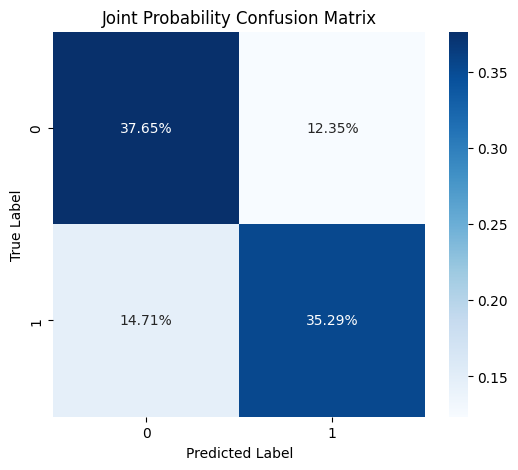

In [42]:
y_pred = best_logit_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_joint_prob = cm / cm.sum()
plt.figure(figsize=(6, 5))
sns.heatmap(cm_joint_prob, annot=True, fmt=".2%", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Joint Probability Confusion Matrix")
plt.show()

## Precision and Recall

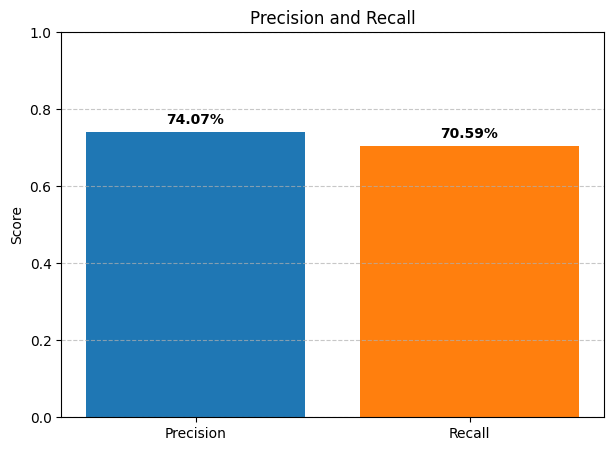

In [44]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
metrics = [precision, recall]
labels = ['Precision', 'Recall']
plt.figure(figsize=(7, 5))
plt.bar(labels, metrics, color=['#1f77b4', '#ff7f0e'])
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Precision and Recall")
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(metrics):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontweight='bold')
plt.show()

# 6: Setup Predictive Model

## Latest March Madness Bracket

In [47]:
def parse_teams(team_div):
    span = team_div.find("span")
    seed = int(span.text.strip()) if span and span.text.strip().isdigit() else None
    links = team_div.find_all("a")
    school = links[0].text.strip() if links else None
    return seed, school


valid_regions = {"East", "Midwest", "West", "South"}
combined_brackets = []
url = f"https://www.sports-reference.com/cbb/postseason/men/{latest_season}-ncaa.html"
headers = {"User-Agent": "Mozilla/5.0"}
r = requests.get(url, headers=headers)
soup = BeautifulSoup(r.content, "html.parser")
brackets_container = soup.find("div", id="brackets")
if not brackets_container:
    raise ValueError(f"Could not find brackets container")
for region_div in brackets_container.find_all("div", recursive=False):
    region_id = region_div.get("id", "").capitalize()
    if region_id not in valid_regions:
        continue  # skip "National" bracket if exists
    bracket_div = region_div.find("div", id="bracket")
    if not bracket_div:
        continue  
    rounds = bracket_div.find_all("div", class_="round")
    if not rounds:
        continue
    round_div = rounds[0]  # Only look at Round 1
    game_divs = [div for div in round_div.find_all("div", recursive=False) if div.find("div", class_="winner")]
    for game in game_divs:
        teams = [d for d in game.find_all("div", recursive=False) if d.name == "div"]
        if len(teams) != 2:
            continue
        seed1, school1 = parse_teams(teams[0])
        seed2, school2 = parse_teams(teams[1])
        combined_brackets.append({
            "Region": region_id,
            "Seed": seed1,
            "School Name": school1,
            "Opponent": school2,
            "Season": latest_season
        })
initial_bracket = pd.DataFrame(combined_brackets)
initial_bracket.reset_index(drop=True, inplace=True)
initial_bracket

Region  Seed        School Name          Opponent  Season
0      East     1               Duke  Mount St. Mary's    2025
1      East     8  Mississippi State            Baylor    2025
2      East     5             Oregon           Liberty    2025
3      East     4            Arizona             Akron    2025
4      East     6                BYU               VCU    2025
5      East     3          Wisconsin           Montana    2025
6      East     7       Saint Mary's        Vanderbilt    2025
7      East     2            Alabama     Robert Morris    2025
8   Midwest     1            Houston  SIU-Edwardsville    2025
9   Midwest     8            Gonzaga           Georgia    2025
10  Midwest     5            Clemson     McNeese State    2025
11  Midwest     4             Purdue        High Point    2025
12  Midwest     6           Illinois            Xavier    2025
13  Midwest     3           Kentucky              Troy    2025
14  Midwest     7               UCLA        Utah State    2025
15  Midwest     2          Tennessee           Wofford    2025
16    South     1             Auburn     Alabama State    2025
17    South     8         Louisville         Creighton    2025
18    South     5           Michigan      UC-San Diego    2025
19    South     4          Texas A&M              Yale    2025
20    South     6           Ole Miss               UNC    2025
21    South     3         Iowa State          Lipscomb    2025
22    South     7          Marquette        New Mexico    2025
23    South     2     Michigan State            Bryant    2025
24     West     1            Florida     Norfolk State    2025
25     West     8              UConn          Oklahoma    2025
26     West     5            Memphis    Colorado State    2025
27     West     4           Maryland      Grand Canyon    2025
28     West     6           Missouri             Drake    2025
29     West     3         Texas Tech    UNC Wilmington    2025
30     West     7             Kansas          Arkansas    2025
31     West     2    St. John's (NY)             Omaha    2025

In [48]:
initial_bracket.drop(columns='Season',inplace=True)
initial_bracket['Seed'] = initial_bracket['Seed'].astype('float64')
initial_bracket.columns = ['Region','Seed','team1','team2']
assert len(initial_bracket) == 32 
initial_bracket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Region  32 non-null     object 
 1   Seed    32 non-null     float64
 2   team1   32 non-null     object 
 3   team2   32 non-null     object 
dtypes: float64(1), object(3)
memory usage: 1.1+ KB


## Latest Season Advanced School Stats

In [50]:
schools_latest.drop(columns=['fta_per_fga_pct','ts_pct','efg_pct'],inplace=True)
assert not schools_latest.isna().values.any()
print(schools_latest.info())
schools_latest

<class 'pandas.core.frame.DataFrame'>
Index: 364 entries, 0 to 363
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             364 non-null    int16  
 1   school_name       364 non-null    object 
 2   win_loss_pct      364 non-null    float32
 3   srs               364 non-null    float32
 4   pace              364 non-null    float32
 5   off_rtg           364 non-null    float32
 6   fg3a_per_fga_pct  364 non-null    float32
 7   trb_pct           364 non-null    float32
 8   ast_pct           364 non-null    float32
 9   stl_pct           364 non-null    float32
 10  blk_pct           364 non-null    float32
 11  tov_pct           364 non-null    float32
 12  orb_pct           364 non-null    float32
 13  ft_rate           364 non-null    float32
dtypes: float32(12), int16(1), object(1)
memory usage: 23.5+ KB
None


index        school_name  win_loss_pct        srs       pace     off_rtg  \
0        0  Abilene Christian         0.500  -5.840000  71.099998   98.599998   
1        1          Air Force         0.125  -8.070000  64.699997   95.000000   
2        2          AkronNCAA         0.800   3.220000  72.500000  115.400002   
3        3        AlabamaNCAA         0.757  25.540001  76.000000  118.500000   
4        4        Alabama A&M         0.313 -20.520000  73.000000   98.400002   
..     ...                ...           ...        ...        ...         ...   
359    376       Wright State         0.455  -4.890000  68.099998  112.199997   
360    378            Wyoming         0.375  -0.670000  65.699997  101.800003   
361    379         XavierNCAA         0.647  15.250000  69.400002  111.699997   
362    380           YaleNCAA         0.733   6.660000  69.000000  117.900002   
363    381   Youngstown State         0.618  -3.850000  70.599998  107.500000   

     fg3a_per_fga_pct    trb_pct    ast_pct  stl_pct  blk_pct    tov_pct  \
0               0.262  50.099998  51.400002     14.4      8.5  18.000000   
1               0.485  46.599998  62.900002      8.7      8.1  18.700001   
2               0.459  52.299999  58.599998     10.5      9.8  14.000000   
3               0.466  53.500000  55.400002      8.1     10.1  14.300000   
4               0.410  49.500000  54.299999     11.2     11.5  18.100000   
..                ...        ...        ...      ...      ...        ...   
359             0.377  51.400002  52.700001      8.3      8.2  15.600000   
360             0.399  51.500000  47.900002      6.7      8.2  16.900000   
361             0.376  50.400002  62.799999     11.1      6.9  14.000000   
362             0.323  54.799999  54.900002      8.4     11.7  12.600000   
363             0.461  50.500000  53.099998      9.8     13.2  14.900000   

       orb_pct  ft_rate  
0    31.799999    0.258  
1    22.700001    0.225  
2    32.700001    0.197  
3    33.700001    0.283  
4    35.099998    0.249  
..         ...      ...  
359  29.000000    0.191  
360  30.700001    0.196  
361  24.400000    0.289  
362  33.000000    0.228  
363  30.900000    0.262  

[364 rows x 14 columns]

## Manual Mapping

In [52]:
print(pd.unique(initial_bracket['team1']),pd.unique(initial_bracket['team2']))

['Duke' 'Mississippi State' 'Oregon' 'Arizona' 'BYU' 'Wisconsin'
 "Saint Mary's" 'Alabama' 'Houston' 'Gonzaga' 'Clemson' 'Purdue'
 'Illinois' 'Kentucky' 'UCLA' 'Tennessee' 'Auburn' 'Louisville' 'Michigan'
 'Texas A&M' 'Ole Miss' 'Iowa State' 'Marquette' 'Michigan State'
 'Florida' 'UConn' 'Memphis' 'Maryland' 'Missouri' 'Texas Tech' 'Kansas'
 "St. John's (NY)"] ["Mount St. Mary's" 'Baylor' 'Liberty' 'Akron' 'VCU' 'Montana'
 'Vanderbilt' 'Robert Morris' 'SIU-Edwardsville' 'Georgia' 'McNeese State'
 'High Point' 'Xavier' 'Troy' 'Utah State' 'Wofford' 'Alabama State'
 'Creighton' 'UC-San Diego' 'Yale' 'UNC' 'Lipscomb' 'New Mexico' 'Bryant'
 'Norfolk State' 'Oklahoma' 'Colorado State' 'Grand Canyon' 'Drake'
 'UNC Wilmington' 'Arkansas' 'Omaha']


In [53]:
# Cross reference the unique school names in the March Madness brackets to the corresponding name on the advanced-school-stats page
# Unfortunately this cannot be properly automated due to idiosyncrasies in naming (ex. UNC, USC, Pitt, UCSB)
# Advanced School Stats page: f"https://www.sports-reference.com/cbb/seasons/men/{latest-season}-advanced-school-stats.html"
# Due to the code structure, each entry in the keep variable must directly correspond to the sequential entry in pd.unique(combined_brackets['team1'])
keep = [
    'DukeNCAA', 'Mississippi StateNCAA', 'OregonNCAA', 'ArizonaNCAA',
    'Brigham YoungNCAA', 'WisconsinNCAA', "Saint Mary's (CA)NCAA",
    'AlabamaNCAA', 'HoustonNCAA', 'GonzagaNCAA', 'ClemsonNCAA', 'PurdueNCAA',
    'IllinoisNCAA', 'KentuckyNCAA', 'UCLANCAA', 'TennesseeNCAA', 'AuburnNCAA',
    'LouisvilleNCAA', 'MichiganNCAA', 'Texas A&MNCAA', 'MississippiNCAA',
    'Iowa StateNCAA', 'MarquetteNCAA', 'Michigan StateNCAA', 'FloridaNCAA',
    'ConnecticutNCAA', 'MemphisNCAA', 'MarylandNCAA', 'MissouriNCAA',
    'Texas TechNCAA', 'KansasNCAA', "St. John's (NY)NCAA", 
    "Mount St. Mary'sNCAA", 'BaylorNCAA', 'LibertyNCAA', 'AkronNCAA',
    'Virginia CommonwealthNCAA', 'MontanaNCAA', 'VanderbiltNCAA',
    'Robert MorrisNCAA', 'SIU EdwardsvilleNCAA', 'GeorgiaNCAA',
    'McNeese StateNCAA', 'High PointNCAA', 'XavierNCAA', 'TroyNCAA',
    'Utah StateNCAA', 'WoffordNCAA', 'Alabama StateNCAA', 'CreightonNCAA',
    'UC San DiegoNCAA', 'YaleNCAA', 'North CarolinaNCAA', 'LipscombNCAA',
    'New MexicoNCAA', 'BryantNCAA', 'Norfolk StateNCAA', 'OklahomaNCAA',
    'Colorado StateNCAA', 'Grand CanyonNCAA', 'DrakeNCAA', 'UNC WilmingtonNCAA',
    'ArkansasNCAA', 'OmahaNCAA'
]
schools_latest = schools_latest[schools_latest['school_name'].isin(keep)]

In [54]:
clean_names = list(pd.unique(initial_bracket['team1'])) + list(pd.unique(initial_bracket['team2']))
name_map = dict(zip(keep, clean_names))
schools_latest['school_name'] = schools_latest['school_name'].replace(name_map)
assert len(keep) == len(schools_latest['school_name'].unique())
assert not schools_latest.isna().values.any()
schools_latest

index    school_name  win_loss_pct        srs       pace     off_rtg  \
2        2          Akron         0.800   3.220000  72.500000  115.400002   
3        3        Alabama         0.757  25.540001  76.000000  118.500000   
5        5  Alabama State         0.556  -8.990000  69.500000  104.699997   
10      10        Arizona         0.649  22.940001  70.400002  116.300003   
12      12       Arkansas         0.611  17.090000  70.300003  108.500000   
..     ...            ...           ...        ...        ...         ...   
340    357            VCU         0.800  14.450000  66.599998  115.099998   
357    374      Wisconsin         0.730  20.730000  68.699997  116.300003   
358    375        Wofford         0.543  -0.130000  65.199997  114.099998   
361    379         Xavier         0.647  15.250000  69.400002  111.699997   
362    380           Yale         0.733   6.660000  69.000000  117.900002   

     fg3a_per_fga_pct    trb_pct    ast_pct  stl_pct  blk_pct  tov_pct  \
2               0.459  52.299999  58.599998     10.5      9.8     14.0   
3               0.466  53.500000  55.400002      8.1     10.1     14.3   
5               0.427  47.700001  45.099998     11.4      8.2     11.1   
10              0.347  55.000000  55.599998     10.6     12.1     13.7   
12              0.366  50.099998  52.099998     10.6     15.0     14.3   
..                ...        ...        ...      ...      ...      ...   
340             0.480  53.299999  56.400002     12.0     15.3     14.1   
357             0.482  51.700001  54.200001      7.5      6.3     12.3   
358             0.480  55.400002  56.000000      9.1      8.6     13.9   
361             0.376  50.400002  62.799999     11.1      6.9     14.0   
362             0.323  54.799999  54.900002      8.4     11.7     12.6   

       orb_pct  ft_rate  
2    32.700001    0.197  
3    33.700001    0.283  
5    28.700001    0.199  
10   36.000000    0.280  
12   28.100000    0.263  
..         ...      ...  
340  36.900002    0.239  
357  28.000000    0.282  
358  36.900002    0.200  
361  24.400000    0.289  
362  33.000000    0.228  

[64 rows x 14 columns]

## Merge DataFrames

In [56]:
merged = initial_bracket.merge(
    schools_latest,
    how='left',               
    left_on='team1',          
    right_on='school_name'    
)
merged.drop(columns=['index','school_name'],inplace=True)
merged = merged.merge(
    schools_latest,
    how='left',               
    left_on='team2',          
    right_on='school_name'    
)
merged.drop(columns=['index','school_name'],inplace=True)
merged

Region  Seed              team1             team2  win_loss_pct_x  \
0      East   1.0               Duke  Mount St. Mary's           0.897   
1      East   8.0  Mississippi State            Baylor           0.618   
2      East   5.0             Oregon           Liberty           0.714   
3      East   4.0            Arizona             Akron           0.649   
4      East   6.0                BYU               VCU           0.722   
5      East   3.0          Wisconsin           Montana           0.730   
6      East   7.0       Saint Mary's        Vanderbilt           0.829   
7      East   2.0            Alabama     Robert Morris           0.757   
8   Midwest   1.0            Houston  SIU-Edwardsville           0.875   
9   Midwest   8.0            Gonzaga           Georgia           0.743   
10  Midwest   5.0            Clemson     McNeese State           0.794   
11  Midwest   4.0             Purdue        High Point           0.667   
12  Midwest   6.0           Illinois            Xavier           0.629   
13  Midwest   3.0           Kentucky              Troy           0.667   
14  Midwest   7.0               UCLA        Utah State           0.676   
15  Midwest   2.0          Tennessee           Wofford           0.789   
16    South   1.0             Auburn     Alabama State           0.842   
17    South   8.0         Louisville         Creighton           0.771   
18    South   5.0           Michigan      UC-San Diego           0.730   
19    South   4.0          Texas A&M              Yale           0.676   
20    South   6.0           Ole Miss               UNC           0.667   
21    South   3.0         Iowa State          Lipscomb           0.714   
22    South   7.0          Marquette        New Mexico           0.676   
23    South   2.0     Michigan State            Bryant           0.811   
24     West   1.0            Florida     Norfolk State           0.900   
25     West   8.0              UConn          Oklahoma           0.686   
26     West   5.0            Memphis    Colorado State           0.829   
27     West   4.0           Maryland      Grand Canyon           0.750   
28     West   6.0           Missouri             Drake           0.647   
29     West   3.0         Texas Tech    UNC Wilmington           0.757   
30     West   7.0             Kansas          Arkansas           0.618   
31     West   2.0    St. John's (NY)             Omaha           0.861   

        srs_x     pace_x   off_rtg_x  fg3a_per_fga_pct_x  trb_pct_x  ...  \
0   30.719999  66.599998  125.000000               0.446  55.200001  ...   
1   17.139999  69.599998  113.000000               0.427  51.500000  ...   
2   18.000000  68.699997  110.199997               0.383  51.500000  ...   
3   22.940001  70.400002  116.300003               0.347  55.000000  ...   
4   19.070000  68.099998  117.599998               0.476  54.299999  ...   
5   20.730000  68.699997  116.300003               0.482  51.700001  ...   
6   17.430000  63.700001  113.599998               0.334  57.500000  ...   
7   25.540001  76.000000  118.500000               0.466  53.500000  ...   
8   28.450001  62.400002  116.199997               0.347  53.900002  ...   
9   23.750000  70.400002  121.500000               0.336  53.799999  ...   
10  17.809999  65.000000  114.400002               0.388  52.000000  ...   
11  20.799999  66.199997  116.800003               0.384  51.700001  ...   
12  21.590000  72.300003  114.800003               0.472  56.000000  ...   
13  21.260000  72.199997  116.500000               0.412  51.900002  ...   
14  19.680000  66.199997  112.000000               0.365  50.900002  ...   
15  24.200001  64.900002  114.000000               0.434  53.500000  ...   
16  28.680000  69.199997  119.599998               0.408  52.700001  ...   
17  18.490000  69.000000  113.300003               0.478  52.700001  ...   
18  20.209999  70.699997  109.500000               0.420  53.000000  ...   
19  19.299999  67.800003  109.199997      

## Feature Engineering

In [58]:
merged.columns = [col[:-2] + '_1' if col.endswith('_x') else col for col in merged.columns]
merged.columns = [col[:-2] + '_2' if col.endswith('_y') else col for col in merged.columns]
for column in merged.columns:
    if column not in ('team1','team2','Region'):
        merged[column] = merged[column].astype('float64')
merged['win_loss_diff'] = merged['win_loss_pct_1'] - merged['win_loss_pct_2']
merged['srs_diff'] = merged['srs_1'] - merged['srs_2']
merged['pace_diff'] = merged['pace_1'] - merged['pace_2']
merged['off_diff'] = merged['off_rtg_1'] - merged['off_rtg_2']
merged['fg3a_diff'] = merged['fg3a_per_fga_pct_1'] - merged['fg3a_per_fga_pct_2']
merged['trb_diff'] = merged['trb_pct_1'] - merged['trb_pct_2']
merged['ast_diff'] = merged['ast_pct_1'] - merged['ast_pct_2']
merged['stl_diff'] = merged['stl_pct_1'] - merged['stl_pct_2']
merged['blk_diff'] = merged['blk_pct_1'] - merged['blk_pct_2']
merged['tov_diff'] = merged['tov_pct_1'] - merged['tov_pct_2']
merged['orb_diff'] = merged['orb_pct_1'] - merged['orb_pct_2']
merged['ft_diff'] = merged['ft_rate_1'] - merged['ft_rate_2']
assert not merged.isna().values.any()
print(merged.info())
merged

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Region              32 non-null     object 
 1   Seed                32 non-null     float64
 2   team1               32 non-null     object 
 3   team2               32 non-null     object 
 4   win_loss_pct_1      32 non-null     float64
 5   srs_1               32 non-null     float64
 6   pace_1              32 non-null     float64
 7   off_rtg_1           32 non-null     float64
 8   fg3a_per_fga_pct_1  32 non-null     float64
 9   trb_pct_1           32 non-null     float64
 10  ast_pct_1           32 non-null     float64
 11  stl_pct_1           32 non-null     float64
 12  blk_pct_1           32 non-null     float64
 13  tov_pct_1           32 non-null     float64
 14  orb_pct_1           32 non-null     float64
 15  ft_rate_1           32 non-null     float64
 16  win_loss_p

Region  Seed              team1             team2  win_loss_pct_1  \
0      East   1.0               Duke  Mount St. Mary's           0.897   
1      East   8.0  Mississippi State            Baylor           0.618   
2      East   5.0             Oregon           Liberty           0.714   
3      East   4.0            Arizona             Akron           0.649   
4      East   6.0                BYU               VCU           0.722   
5      East   3.0          Wisconsin           Montana           0.730   
6      East   7.0       Saint Mary's        Vanderbilt           0.829   
7      East   2.0            Alabama     Robert Morris           0.757   
8   Midwest   1.0            Houston  SIU-Edwardsville           0.875   
9   Midwest   8.0            Gonzaga           Georgia           0.743   
10  Midwest   5.0            Clemson     McNeese State           0.794   
11  Midwest   4.0             Purdue        High Point           0.667   
12  Midwest   6.0           Illinois            Xavier           0.629   
13  Midwest   3.0           Kentucky              Troy           0.667   
14  Midwest   7.0               UCLA        Utah State           0.676   
15  Midwest   2.0          Tennessee           Wofford           0.789   
16    South   1.0             Auburn     Alabama State           0.842   
17    South   8.0         Louisville         Creighton           0.771   
18    South   5.0           Michigan      UC-San Diego           0.730   
19    South   4.0          Texas A&M              Yale           0.676   
20    South   6.0           Ole Miss               UNC           0.667   
21    South   3.0         Iowa State          Lipscomb           0.714   
22    South   7.0          Marquette        New Mexico           0.676   
23    South   2.0     Michigan State            Bryant           0.811   
24     West   1.0            Florida     Norfolk State           0.900   
25     West   8.0              UConn          Oklahoma           0.686   
26     West   5.0            Memphis    Colorado State           0.829   
27     West   4.0           Maryland      Grand Canyon           0.750   
28     West   6.0           Missouri             Drake           0.647   
29     West   3.0         Texas Tech    UNC Wilmington           0.757   
30     West   7.0             Kansas          Arkansas           0.618   
31     West   2.0    St. John's (NY)             Omaha           0.861   

        srs_1     pace_1   off_rtg_1  fg3a_per_fga_pct_1  trb_pct_1  ...  \
0   30.719999  66.599998  125.000000               0.446  55.200001  ...   
1   17.139999  69.599998  113.000000               0.427  51.500000  ...   
2   18.000000  68.699997  110.199997               0.383  51.500000  ...   
3   22.940001  70.400002  116.300003               0.347  55.000000  ...   
4   19.070000  68.099998  117.599998               0.476  54.299999  ...   
5   20.730000  68.699997  116.300003               0.482  51.700001  ...   
6   17.430000  63.700001  113.599998               0.334  57.500000  ...   
7   25.540001  76.000000  118.500000               0.466  53.500000  ...   
8   28.450001  62.400002  116.199997               0.347  53.900002  ...   
9   23.750000  70.400002  121.500000               0.336  53.799999  ...   
10  17.809999  65.000000  114.400002               0.388  52.000000  ...   
11  20.799999  66.199997  116.800003               0.384  51.700001  ...   
12  21.590000  72.300003  114.800003               0.472  56.000000  ...   
13  21.260000  72.199997  116.500000               0.412  51.900002  ...   
14  19.680000  66.199997  112.000000               0.365  50.900002  ...   
15  24.200001  64.900002  114.000000               0.434  53.500000  ...   
16  28.680000  69.199997  119.599998               0.408  52.700001  ...   
17  18.490000  69.000000  113.300003               0.478  52.700001  ...   
18  20.209999  70.699997  109.500000               0.420  53.000000  ...   
19  19.299999  67.800003  109.199997      

# 7: Predict Round 1 Wins

In [60]:
east_bracket_1 = merged[merged['Region'] == 'East']
west_bracket_1 = merged[merged['Region'] == 'West']
midwest_bracket_1 = merged[merged['Region'] == 'Midwest']
south_bracket_1 = merged[merged['Region'] == 'South']
round1 = [east_bracket_1, west_bracket_1, midwest_bracket_1, south_bracket_1]

## Apply Logistic Model

In [62]:
for region in round1:
    region.drop(columns='Region', inplace=True)
    X = region.drop(columns=['team1', 'team2'])
    best_logit_model = logit_rs.best_estimator_
    region['team1_win'] = best_logit_model.predict(X)
    # Outputs whether team1 wins (1) or team1 losses (0)

## Advance Winning Teams 

In [64]:
def advance_to_round_2(regions, remaining_matches):
    """
    Updates the given list of region DataFrames to the 2nd round:
    - Marks eliminated teams
    - Copies stats of advancing teams based on opponent
    - Updates team names explicitly to the advancing opponent
    - Recomputes difference columns
    - Filters out eliminated rows
    Returns a list of updated regions.
    """
    metrics = [
        'win_loss_pct', 'srs', 'pace', 'off_rtg', 
        'fg3a_per_fga_pct', 'trb_pct', 'ast_pct',
        'stl_pct', 'blk_pct', 'tov_pct', 'orb_pct', 'ft_rate'
    ]
    updated_regions = []
    for region in regions:
        region = region.copy()
        # Mark eliminated teams
        for idx, row in region.iterrows():
            if row['team1_win'] == 1:
                region.loc[idx, 'team2'] = 'Eliminated'
            else:
                region.loc[idx, 'team1'] = 'Eliminated'
        # Advance stats & names to next round
        for i in range(1, 5):  # Seeds 1 to 4
            next_opponent = 9 - i
            row_i = region[region['Seed'] == i]
            row_opp = region[region['Seed'] == next_opponent]
            if row_i.empty or row_opp.empty:
                continue
            i_idx = row_i.index[0]
            i_row = row_i.iloc[0]
            opp_row = row_opp.iloc[0]
            # Decide which team field to update based on eliminated opponents
            if i_row['team2'] == 'Eliminated' and opp_row['team2'] == 'Eliminated':
                src_prefix = '1'
                dest_prefix = '2'
            elif i_row['team2'] == 'Eliminated' and opp_row['team1'] == 'Eliminated':
                src_prefix = '2'
                dest_prefix = '2'
            elif i_row['team1'] == 'Eliminated' and opp_row['team1'] == 'Eliminated':
                src_prefix = '2'
                dest_prefix = '1'
            elif i_row['team1'] == 'Eliminated' and opp_row['team2'] == 'Eliminated':
                src_prefix = '1'
                dest_prefix = '1'
            else:
                continue
            # Copy metrics & team name
            for metric in metrics:
                src_col = f"{metric}_{src_prefix}"
                dest_col = f"{metric}_{dest_prefix}"
                region.loc[i_idx, dest_col] = opp_row[src_col]
            # Update team name explicitly
            region.loc[i_idx, f"team{dest_prefix}"] = opp_row[f"team{src_prefix}"]
            # Recompute interaction variables
            for metric in metrics:
                diff_col = f"{metric.split('_')[0]}_diff"
                region.loc[i_idx, diff_col] = (
                    region.loc[i_idx, f"{metric}_1"] - region.loc[i_idx, f"{metric}_2"]
                )
        # Filter out eliminated teams
        region_new = region[(region['team1'] != 'Eliminated') & (region['team2'] != 'Eliminated')]
        assert len(region_new) == remaining_matches, f"Unexpected number of rows: {len(region_new)}"
        region_new.drop(columns=['win_diff'],inplace=True)
        assert len(region_new.columns) == 40
        updated_regions.append(region_new)
    return updated_regions

In [65]:
updated_regions = advance_to_round_2(round1,4)

# 8: Predict Round 2 Wins

In [67]:
east_bracket_2 = pd.DataFrame(updated_regions[0]).drop(columns='team1_win')  # Don't get confused between advancing and predicting
west_bracket_2 = pd.DataFrame(updated_regions[1]).drop(columns='team1_win')
midwest_bracket_2 = pd.DataFrame(updated_regions[2]).drop(columns='team1_win')
south_bracket_2 = pd.DataFrame(updated_regions[3]).drop(columns='team1_win')
round2 = [east_bracket_2,west_bracket_2,midwest_bracket_2,south_bracket_2]

## Apply Logistic Model

In [69]:
for region in round2:
    X = region.drop(columns=['team1', 'team2'])
    best_logit_model = logit_rs.best_estimator_
    region['team1_win'] = best_logit_model.predict(X)

## Advance Winning Teams 

In [71]:
def advance_to_round_3(regions, remaining_matches):
    """
    Updates the given list of region DataFrames for the 3rd round:
    - Marks eliminated teams
    - Copies stats of advancing teams based on opponent
    - Updates team names explicitly to the advancing opponent
    - Recomputes difference columns
    - Filters out eliminated rows
    Returns a list of updated regions.
    """
    metrics = [
        'win_loss_pct', 'srs', 'pace', 'off_rtg', 
        'fg3a_per_fga_pct', 'trb_pct', 'ast_pct',
        'stl_pct', 'blk_pct', 'tov_pct', 'orb_pct', 'ft_rate'
    ]
    updated_regions = []
    for region in regions:
        region = region.copy()
        # Mark eliminated teams
        for idx, row in region.iterrows():
            if row['team1_win'] == 1:
                region.loc[idx, 'team2'] = 'Eliminated'
            else:
                region.loc[idx, 'team1'] = 'Eliminated'
        # Advance stats & names to next round
        for i in range(1, 3):  # Seeds 1 to 2
            next_opponent = 5 - i
            row_i = region[region['Seed'] == i]
            row_opp = region[region['Seed'] == next_opponent]
            if row_i.empty or row_opp.empty:
                continue
            i_idx = row_i.index[0]
            i_row = row_i.iloc[0]
            opp_row = row_opp.iloc[0]
            # Decide which team field to update based on eliminated opponents
            if i_row['team2'] == 'Eliminated' and opp_row['team2'] == 'Eliminated':
                src_prefix = '1'
                dest_prefix = '2'
            elif i_row['team2'] == 'Eliminated' and opp_row['team1'] == 'Eliminated':
                src_prefix = '2'
                dest_prefix = '2'
            elif i_row['team1'] == 'Eliminated' and opp_row['team1'] == 'Eliminated':
                src_prefix = '2'
                dest_prefix = '1'
            elif i_row['team1'] == 'Eliminated' and opp_row['team2'] == 'Eliminated':
                src_prefix = '1'
                dest_prefix = '1'
            else:
                continue
            # Copy metrics & team name
            for metric in metrics:
                src_col = f"{metric}_{src_prefix}"
                dest_col = f"{metric}_{dest_prefix}"
                region.loc[i_idx, dest_col] = opp_row[src_col]
            # Update team name explicitly
            region.loc[i_idx, f"team{dest_prefix}"] = opp_row[f"team{src_prefix}"]
            # Recompute interaction variables
            for metric in metrics:
                diff_col = f"{metric.split('_')[0]}_diff"
                region.loc[i_idx, diff_col] = (
                    region.loc[i_idx, f"{metric}_1"] - region.loc[i_idx, f"{metric}_2"]
                )
        # Filter out eliminated teams
        region_new = region[(region['team1'] != 'Eliminated') & (region['team2'] != 'Eliminated')]
        assert len(region_new) == remaining_matches, f"Unexpected number of rows: {len(region_new)}"
        region_new.drop(columns=['win_diff'],inplace=True)
        assert len(region_new.columns) == 40
        updated_regions.append(region_new)
    return updated_regions

In [72]:
updated_regions = advance_to_round_3(round2,2)

# 9: Predict Round 3 Wins

In [74]:
east_bracket_3 = pd.DataFrame(updated_regions[0]).drop(columns='team1_win')
west_bracket_3 = pd.DataFrame(updated_regions[1]).drop(columns='team1_win')
midwest_bracket_3 = pd.DataFrame(updated_regions[2]).drop(columns='team1_win')
south_bracket_3 = pd.DataFrame(updated_regions[3]).drop(columns='team1_win')
round3 = [east_bracket_3,west_bracket_3,midwest_bracket_3,south_bracket_3]

## Apply Logistic Model

In [76]:
for region in round3:
    X = region.drop(columns=['team1', 'team2'])
    best_logit_model = logit_rs.best_estimator_
    region['team1_win'] = best_logit_model.predict(X)

## Advance Winning Teams

In [78]:
def advance_to_round_4(regions, remaining_matches):
    """
    Updates the given list of region DataFrames for the 4th round:
    - Marks eliminated teams
    - Copies stats of advancing teams based on opponent
    - Updates team names explicitly to the advancing opponent
    - Recomputes difference columns
    - Filters out eliminated rows
    Returns a list of updated regions.
    """
    metrics = [
        'win_loss_pct', 'srs', 'pace', 'off_rtg',
        'fg3a_per_fga_pct', 'trb_pct', 'ast_pct',
        'stl_pct', 'blk_pct', 'tov_pct', 'orb_pct', 'ft_rate'
    ]
    updated_regions = []
    for region in regions:
        region = region.copy()
        # Mark eliminated teams
        for idx, row in region.iterrows():
            if row['team1_win'] == 1:
                region.loc[idx, 'team2'] = 'Eliminated'
            else:
                region.loc[idx, 'team1'] = 'Eliminated'
        # Advance stats & names to next round
        i = 1
        next_opponent = 2
        row_i = region[region['Seed'] == i]
        row_opp = region[region['Seed'] == next_opponent]
        if row_i.empty or row_opp.empty:
            continue
        i_idx = row_i.index[0]
        i_row = row_i.iloc[0]
        opp_row = row_opp.iloc[0]
        # Decide which team fields to update based on eliminated opponents
        if i_row['team2'] == 'Eliminated' and opp_row['team2'] == 'Eliminated':
            src_prefix = '1'
            dest_prefix = '2'
        elif i_row['team2'] == 'Eliminated' and opp_row['team1'] == 'Eliminated':
            src_prefix = '2'
            dest_prefix = '2'
        elif i_row['team1'] == 'Eliminated' and opp_row['team1'] == 'Eliminated':
            src_prefix = '2'
            dest_prefix = '1'
        elif i_row['team1'] == 'Eliminated' and opp_row['team2'] == 'Eliminated':
            src_prefix = '1'
            dest_prefix = '1'
        else:
            continue
        # Copy metrics & team name
        for metric in metrics:
            src_col = f"{metric}_{src_prefix}"
            dest_col = f"{metric}_{dest_prefix}"
            region.loc[i_idx, dest_col] = opp_row[src_col]
        # Update team name explicitly
        region.loc[i_idx, f"team{dest_prefix}"] = opp_row[f"team{src_prefix}"]
        # Recompute interaction variables
        for metric in metrics:
            diff_col = f"{metric.split('_')[0]}_diff"
            region.loc[i_idx, diff_col] = (
                region.loc[i_idx, f"{metric}_1"] - region.loc[i_idx, f"{metric}_2"]
            )
        # Filter out eliminated teams
        region_new = region[(region['team1'] != 'Eliminated') & (region['team2'] != 'Eliminated')]
        assert len(region_new) == remaining_matches, f"Unexpected number of rows: {len(region_new)}"
        region_new.drop(columns=['win_diff'],inplace=True)
        assert len(region_new.columns) == 40
        updated_regions.append(region_new)
    return updated_regions

In [79]:
updated_regions = advance_to_round_4(round3,1)

# 10: Predict Round 4 Wins

In [81]:
east_bracket_4 = pd.DataFrame(updated_regions[0]).drop(columns='team1_win')
west_bracket_4 = pd.DataFrame(updated_regions[1]).drop(columns='team1_win')
midwest_bracket_4 = pd.DataFrame(updated_regions[2]).drop(columns='team1_win')
south_bracket_4 = pd.DataFrame(updated_regions[3]).drop(columns='team1_win')
round4 = [east_bracket_4,west_bracket_4,midwest_bracket_4,south_bracket_4]

## Apply Logistic Model

In [83]:
for region in round4:
    X = region.drop(columns=['team1', 'team2'])
    best_logit_model = logit_rs.best_estimator_
    region['team1_win'] = best_logit_model.predict(X)

## Combine Winners of Each Region

In [85]:
east_bracket_4['Region'] = 'East'
midwest_bracket_4['Region'] = 'Midwest'
south_bracket_4['Region'] = 'South'
west_bracket_4['Region'] = 'West'
semifinals = pd.concat([east_bracket_4, west_bracket_4],ignore_index=True)
semifinals = pd.concat([semifinals, midwest_bracket_4],ignore_index=True)
semifinals = pd.concat([semifinals, south_bracket_4],ignore_index=True)
semifinals

Seed       team1       team2  win_loss_pct_1      srs_1     pace_1  \
0   1.0        Duke     Alabama           0.897  30.719999  66.599998   
1   1.0  Texas Tech    Maryland           0.757  23.049999  66.500000   
2   1.0     Houston    Kentucky           0.875  28.450001  62.400002   
3   1.0      Auburn  Iowa State           0.842  28.680000  69.199997   

    off_rtg_1  fg3a_per_fga_pct_1  trb_pct_1  ast_pct_1  ...  fg3a_diff  \
0  125.000000               0.446  55.200001  58.599998  ...     -0.020   
1  119.500000               0.445  53.099998  57.200001  ...      0.091   
2  116.199997               0.347  53.900002  45.099998  ...     -0.065   
3  119.599998               0.408  52.700001  54.900002  ...      0.040   

   trb_diff   ast_diff  stl_diff  blk_diff  tov_diff  orb_diff  ft_diff  \
0  1.700001   3.199997       2.0  0.799999 -2.200000  0.299999   -0.023   
1  1.399998   8.100002      -1.9 -3.500000 -0.299999  3.500000   -0.026   
2  2.000000 -11.900002       2.7  4.400001 -1.400000  8.700001   -0.056   
3 -0.299999   1.500000      -3.3  5.700000 -3.200000  2.000000   -0.038   

   team1_win   Region  
0        1.0     East  
1        1.0     West  
2        1.0  Midwest  
3        1.0    South  

[4 rows x 41 columns]

## Advance Winning Teams

In [87]:
def advance_national_round(df, remaining_matches):
    """
    Advance to the next national round:
    - Marks eliminated teams
    - Copies stats of advancing teams from winning region opponent
    - Updates team names explicitly
    - Recomputes difference columns
    - Filters out eliminated rows
    Returns updated DataFrame.
    """
    metrics = [
        'win_loss_pct', 'srs', 'pace', 'off_rtg',
        'fg3a_per_fga_pct', 'trb_pct', 'ast_pct',
        'stl_pct', 'blk_pct', 'tov_pct', 'orb_pct', 'ft_rate'
    ]
    df = df.copy()
    # Mark eliminated teams
    for idx, row in df.iterrows():
        if row['team1_win'] == 1:
            df.loc[idx, 'team2'] = 'Eliminated'
        else:
            df.loc[idx, 'team1'] = 'Eliminated'
    # Define region pairings (South against West; Midwest against East)
    pairings = {
        'South': 'West',
        'Midwest': 'East'
    }
    updated_rows = []
    for region1, region2 in pairings.items():
        row1 = df[df['Region'] == region1]
        row2 = df[df['Region'] == region2]
        if row1.empty or row2.empty:
            continue
        idx1, idx2 = row1.index[0], row2.index[0]
        r1, r2 = row1.iloc[0], row2.iloc[0]
        # Determine which prefix to copy based on eliminated teams
        if r1['team2'] == 'Eliminated' and r2['team2'] == 'Eliminated':
            src_prefix = '1'; dest_prefix = '2'
        elif r1['team2'] == 'Eliminated' and r2['team1'] == 'Eliminated':
            src_prefix = '2'; dest_prefix = '2'
        elif r1['team1'] == 'Eliminated' and r2['team1'] == 'Eliminated':
            src_prefix = '2'; dest_prefix = '1'
        elif r1['team1'] == 'Eliminated' and r2['team2'] == 'Eliminated':
            src_prefix = '1'; dest_prefix = '1'
        else:
            continue
        # Copy opponent stats & update team name explicitly
        for metric in metrics:
            src_col = f"{metric}_{src_prefix}"
            dest_col = f"{metric}_{dest_prefix}"
            df.loc[idx1, dest_col] = r2[src_col]
        df.loc[idx1, f"team{dest_prefix}"] = r2[f"team{src_prefix}"]
        # Recompute interaction variables
        for metric in metrics:
            diff_col = f"{metric.split('_')[0]}_diff"
            df.loc[idx1, diff_col] = (
                df.loc[idx1, f"{metric}_1"] - df.loc[idx1, f"{metric}_2"]
            )
        updated_rows.append(idx1)
    # Keep only updated & surviving rows
    semifinals = df.loc[updated_rows].copy()
    semifinals = semifinals[(semifinals['team1'] != 'Eliminated') & (semifinals['team2'] != 'Eliminated')]
    assert len(semifinals) == remaining_matches, f"Unexpected number of rows: {len(semifinals)}"
    semifinals.drop(columns=['win_diff'], inplace=True)
    semifinals.drop(columns='Region',inplace=True)
    assert len(semifinals.columns) == 40
    return semifinals

In [88]:
semifinals = advance_national_round(semifinals,2)

# 11: Predict Semifinals Wins

## Apply Logistic Model

In [91]:
X = semifinals.drop(columns=['team1', 'team2','team1_win'])
best_logit_model = logit_rs.best_estimator_
semifinals['team1_win'] = best_logit_model.predict(X)

## Advance Winning Teams

In [93]:
def advance_final_round(df):
    """
    Advance to the final round:
    - Marks eliminated team in each row
    - Copies stats of the opponent into the winning row
    - Updates team names explicitly
    - Recomputes difference columns
    - Filters out eliminated row
    Returns a single-row DataFrame with the champion matchup.
    """
    metrics = [
        'win_loss_pct', 'srs', 'pace', 'off_rtg',
        'fg3a_per_fga_pct', 'trb_pct', 'ast_pct',
        'stl_pct', 'blk_pct', 'tov_pct', 'orb_pct', 'ft_rate'
    ]
    df = df.copy()
    # Determine which row is the winner
    if df.iloc[0]['team1_win'] == 1:
        winner_idx, loser_idx = df.index[0], df.index[1]
        df.loc[loser_idx, 'team1'] = 'Eliminated'
    else:
        winner_idx, loser_idx = df.index[1], df.index[0]
        df.loc[loser_idx, 'team1'] = 'Eliminated'
    winner_row = df.loc[winner_idx]
    loser_row  = df.loc[loser_idx]
    # Determine which team in the winner row won
    if winner_row['team1_win'] == 1:
        winner_team = '1'
        loser_team  = '2'
    else:
        winner_team = '2'
        loser_team  = '1'
    # Mark losing team explicitly
    df.loc[winner_idx, f'team{loser_team}'] = 'Eliminated'
    # Copy opponent stats & update name in the winner row
    for metric in metrics:
        src_col  = f"{metric}_{winner_team}"
        dest_col = f"{metric}_{loser_team}"
        df.loc[winner_idx, dest_col] = loser_row[src_col]
    df.loc[winner_idx, f"team{loser_team}"] = loser_row[f"team{winner_team}"]
    # Recompute interaction variables
    for metric in metrics:
        diff_col = f"{metric.split('_')[0]}_diff"
        df.loc[winner_idx, diff_col] = (
            df.loc[winner_idx, f"{metric}_1"] - df.loc[winner_idx, f"{metric}_2"]
        )
    # Keep only the champion matchup row
    champion_df = df.loc[[winner_idx]].copy()
    champion_df = champion_df[
        (champion_df['team1'] != 'Eliminated') & (champion_df['team2'] != 'Eliminated')
    ]
    assert len(champion_df) == 1, f"Unexpected number of rows: {len(champion_df)}"
    champion_df.drop(columns=['win_diff'], inplace=True)
    assert len(champion_df.columns) == 40
    return champion_df

In [94]:
champion_df = advance_final_round(semifinals).drop(columns='team1_win')

# 12: Predict Final Round Winner

In [96]:
X = champion_df.drop(columns=['team1', 'team2'])
best_logit_model = logit_rs.best_estimator_
champion_df['team1_win'] = best_logit_model.predict(X)

In [97]:
winner = champion_df.copy()
if winner.iloc[0, -1] == 0:
    winner['team1'] = 'Eliminated'
else:
    winner['team2'] = 'Eliminated'
winner

Seed       team1    team2  win_loss_pct_1  srs_1     pace_1   off_rtg_1  \
3   1.0  Eliminated  Houston           0.842  28.68  69.199997  119.599998   

   fg3a_per_fga_pct_1  trb_pct_1  ast_pct_1  ...  off_diff  fg3a_diff  \
3               0.408  52.700001  54.900002  ...  3.400002      0.061   

   trb_diff  ast_diff  stl_diff  blk_diff  tov_diff  orb_diff  ft_diff  \
3 -1.200001  9.800003      -2.3       0.0      -0.1 -2.700001    0.046   

   team1_win  
3        0.0  

[1 rows x 40 columns]

# 13: Completed March Madness Prediction

In [99]:
def build_match_history(bracket_dfs):
    """
    Given a list of (df, round_name, region_name) tuples,
    build a master DataFrame of matches with columns:
    ['Region', 'Round', 'Seed', 'team1', 'team2', 'Result'].
    """
    all_rows = []
    for df, round_name, region_name in bracket_dfs:
        for idx, row in df.iterrows():
            result = 'W' if row['team1_win'] == 1 else 'L'
            all_rows.append({
                'Region': region_name,
                'Round': round_name,
                'Seed': row['Seed'],
                'team1': row['team1'],
                'team2': row['team2'],
                'team1_Result': result
            })
    master_df = pd.DataFrame(all_rows)
    return master_df

In [100]:
bracket_dfs = [
    (east_bracket_1,   'Round 1', 'East'),
    (west_bracket_1,   'Round 1', 'West'),
    (midwest_bracket_1,'Round 1', 'Midwest'),
    (south_bracket_1,  'Round 1', 'South'),
    (east_bracket_2,   'Round 2', 'East'),
    (west_bracket_2,   'Round 2', 'West'),
    (midwest_bracket_2,'Round 2', 'Midwest'),
    (south_bracket_2,  'Round 2', 'South'),
    (east_bracket_3,   'Round 3', 'East'),
    (west_bracket_3,   'Round 3', 'West'),
    (midwest_bracket_3,'Round 3', 'Midwest'),
    (south_bracket_3,  'Round 3', 'South'),
    (east_bracket_4,   'Round 4', 'East'),
    (west_bracket_4,   'Round 4', 'West'),
    (midwest_bracket_4,'Round 4', 'Midwest'),
    (south_bracket_4,  'Round 4', 'South'),
    (semifinals,       'Semifinal', 'Nationals'),
    (champion_df,      'Final', 'Nationals'),
]

In [101]:
master_df = build_match_history(bracket_dfs)
master_df

Region      Round  Seed              team1             team2 Result
0        East    Round 1   1.0               Duke  Mount St. Mary's      W
1        East    Round 1   8.0  Mississippi State            Baylor      W
2        East    Round 1   5.0             Oregon           Liberty      W
3        East    Round 1   4.0            Arizona             Akron      W
4        East    Round 1   6.0                BYU               VCU      L
..        ...        ...   ...                ...               ...    ...
58    Midwest    Round 4   1.0            Houston          Kentucky      W
59      South    Round 4   1.0             Auburn        Iowa State      W
60  Nationals  Semifinal   1.0             Auburn        Texas Tech      W
61  Nationals  Semifinal   1.0            Houston              Duke      L
62  Nationals      Final   1.0             Auburn           Houston      L

[63 rows x 6 columns]